In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [122]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, aggregator, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def generateUnitSalePrice(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		for i in range(self.totalHours):
			self.unitSalePrice[i] = random.uniform(minPrice[i], maxPrice[i])

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, 100000)
		self.m = m

	def utilityFunction(self, m, theta, omega):
		# self.generateUnitSalePrice()
		self.generateM()
		print(self.m)

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(agg, j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*m
			mx = max(mx, sum)
		return mx

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = []

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO):
		self.bestLoadResponse = []
		for j in range(DSO.totalHours):
			self.bestLoadResponse.append((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference) / DSO.unitSalePrice[j])))


In [123]:
datasetPath = '../dataset/'

In [124]:
numOfLA = 3
numOfHours = 50

In [125]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	# Power is in kW
	nominalDemands.append(df['Power'].tolist())

In [126]:
LAs = []
maxPriceReference = 30
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.0001, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 5, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [127]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [128]:
marginalCost = np.random.randint(1, 7, numOfHours) # cent/kW
unitSalePrice = np.random.randint(1, 7, numOfHours)
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [129]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [130]:
# # print all the values for the DSO
# print("DSO")
# print("marginal cost: ", dso.marginalCost)
# print("unit sale price: ", dso.unitSalePrice)


In [131]:
dso.generateUnitSalePrice()

In [132]:
# DSO gives the price for each hour & each LA calculates the optimal DR
for i in range(numOfLA):
	# la = LAs[i]
	la = dso.aggregators[i]
	la.optimalDR(dso)

In [133]:
# # print best load response for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("best load response: ", dso.aggregators[i].bestLoadResponse)

In [134]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
# theta = np.random.uniform(0.1, 1)
# omega = np.random.uniform(0.1, 1)
theta = 0.01
omega = 5
dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

72446.63227790172


2229.0558670786336

In [135]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  726.9695763500478
LA 1
utility:  5574.108653810624
LA 2
utility:  2347.9751540681714


In [136]:
dso.getPAR()

51912.98610660016

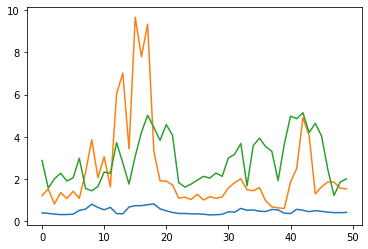

In [137]:
# plot nominal demand of each LA
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.show()

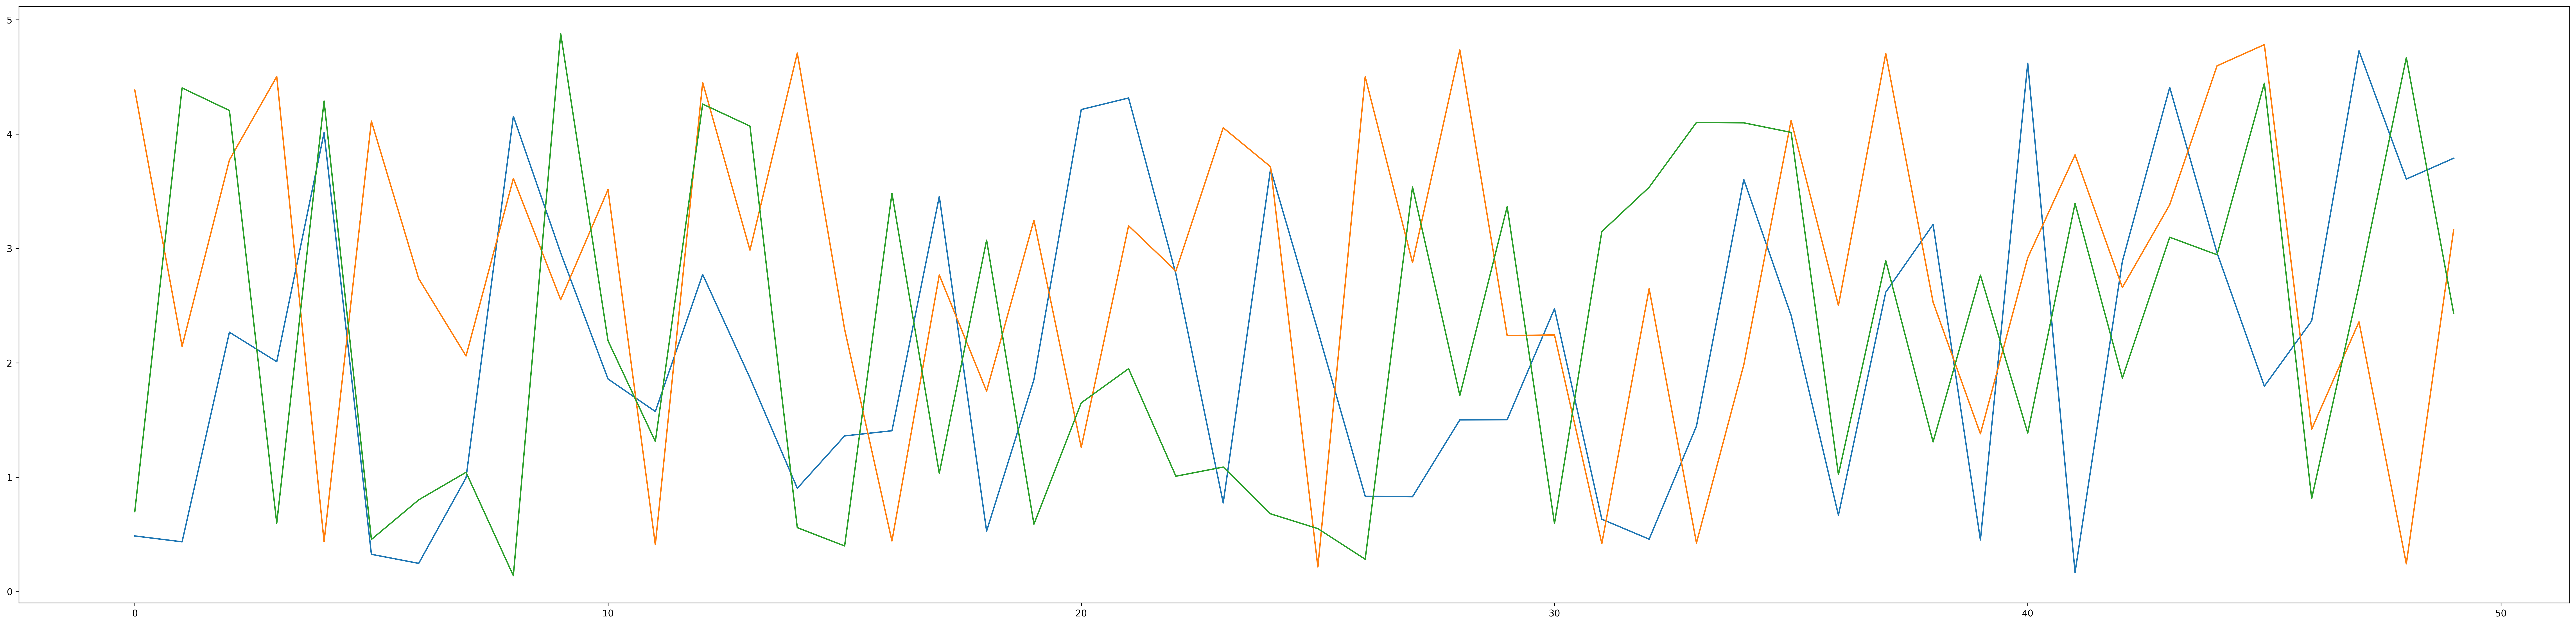

In [138]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction)
plt.show()

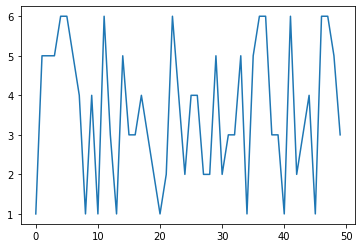

In [139]:
# plot marginal cost
plt.plot(dso.marginalCost)
plt.show()

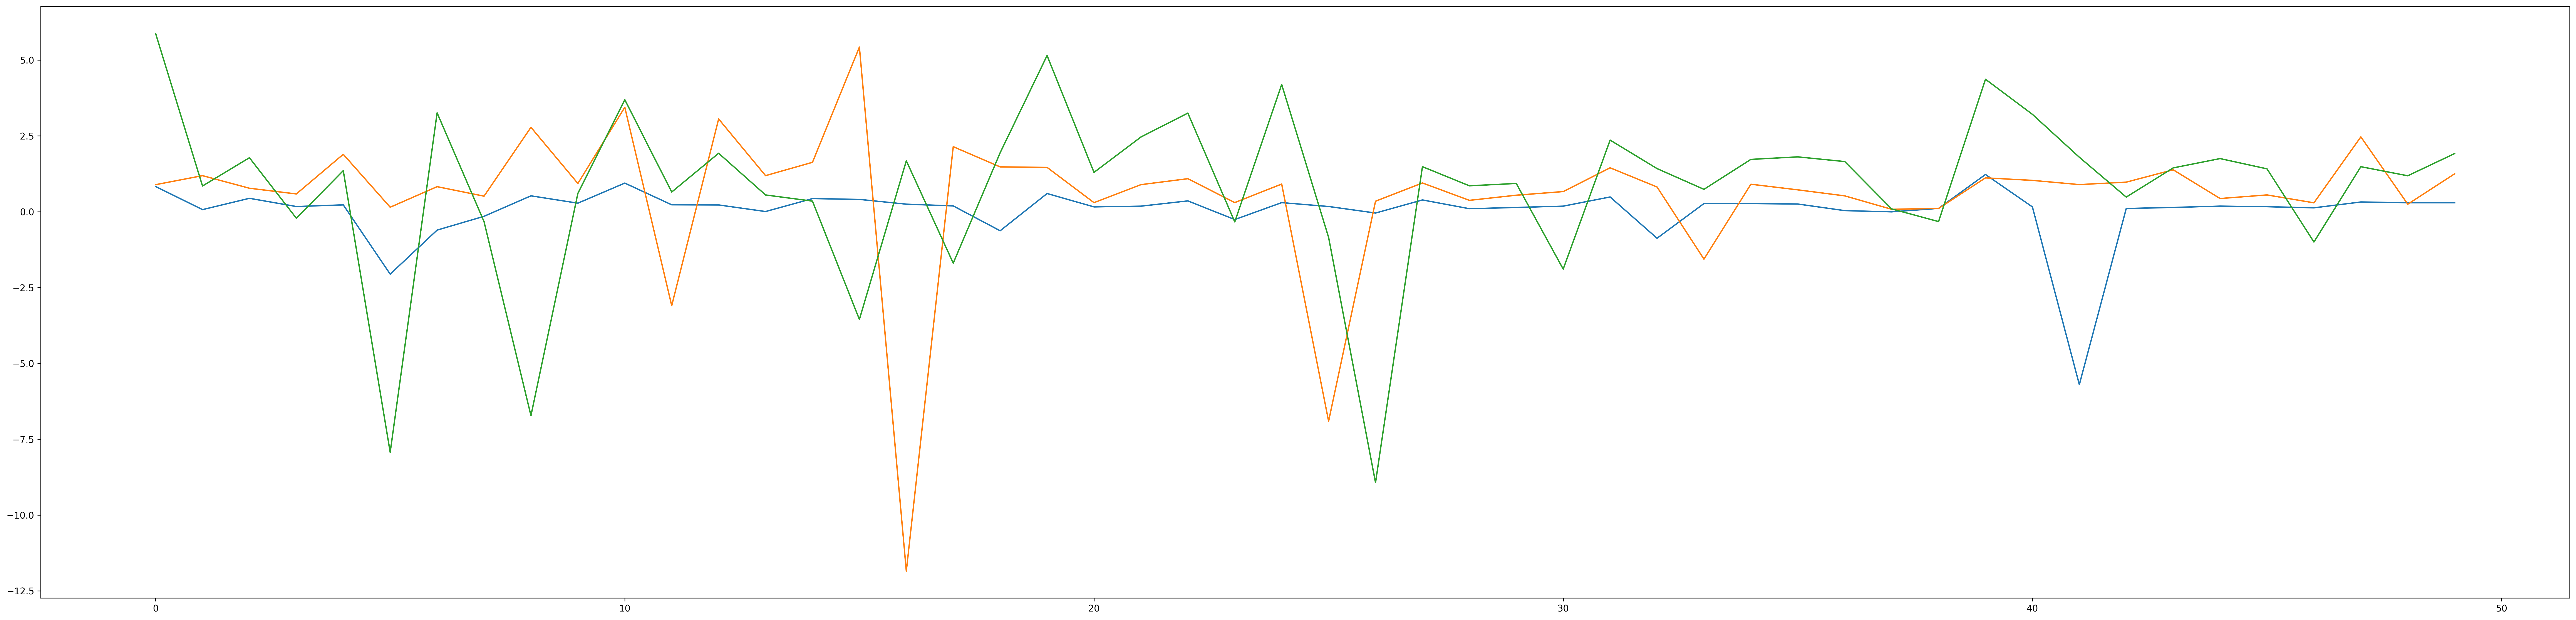

In [140]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse)
plt.show()